/Users/mgrecu/miniconda3/lib/python3.9/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,


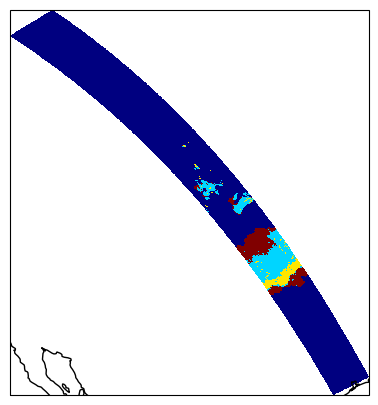

In [113]:
import io_subs
from pyresample import image, geometry
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import importlib
importlib.reload(io_subs)

wf = lambda r: 1 - r/20000.0
import netCDF4 as nc
#!ls Data/
n1,n2=4600,5230
f='Data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20180625-S050505-E051345.024557.V07A.HDF5'
f='Data/2B.GPM.DPRGMI.CORRA2022OE.20180625-S041042-E054316.024557.ITE790.HDF5'
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,oe_wvp,oe_lwp,oe_iwp,oesfc_precip,stormTop,nearSfcPrecip,zeroDeg=io_subs.readCMB(f)
with nc.Dataset(f) as ncF:
    #print(ncF['KuKaGMI/Input/'])
    surfaceType=ncF['KuKaGMI/Input/surfaceType'][n1:n2,:]   
f1='Data/1C.GPM.GMI.XCAL2016-C.20180625-S041042-E054316.024557.V07A.HDF5'
lat_s1,lon_s1,tb_s1=io_subs.read1CGMI(f1)


qv=qv[n1:n2]
press=press[n1:n2]
envNodes=envNodes[n1:n2]
airTemp=airTemp[n1:n2]
skTemp=skTemp[n1:n2]
binNodes=binNodes[n1:n2]
pwc=pwc[n1:n2]
sfcEmiss=sfcEmiss[n1:n2]
dm=dm[n1:n2]
cldw=cldw[n1:n2]
sfcBin=sfcBin[n1:n2]
zCorrected=zCorrected[n1:n2]
pType=pType[n1:n2]
lon=lon[n1:n2]
lat=lat[n1:n2]
oe_wvp=oe_wvp[n1:n2]
oe_lwp=oe_lwp[n1:n2]
oe_iwp=oe_iwp[n1:n2]
oesfc_precip=oesfc_precip[n1:n2]
stormTop=stormTop[n1:n2]
nearSfcPrecip=nearSfcPrecip[n1:n2]
zeroDeg=zeroDeg[n1:n2]

# Define the input and output grids
input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling

tb_s1_resampled = resample_custom(input_def, tb_s1[:,:,:], output_def, radius_of_influence=30000, neighbours=10, 
weight_funcs=[wf for k in range(9)], fill_value=None)
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
pTypem=np.ma.array(pType,mask=skTemp<273.15)
ax.coastlines()

plt.pcolormesh(lon,lat,pTypem/1e7,cmap='jet')
astorm=np.nonzero(stormTop.data<-9)
stormTop[astorm]=0

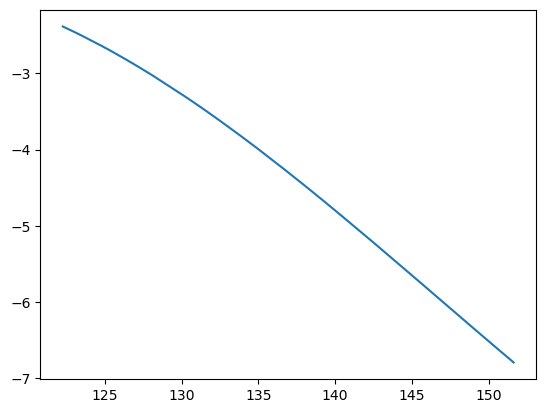

In [70]:
with nc.Dataset(f1) as fgmi:
    #print(fgmi['S1'])
    SClat=fgmi['S1/SCstatus/SClatitude'][:]
    SClon=fgmi['S1/SCstatus/SClongitude'][:]
    SCorientation=fgmi['S1/SCstatus/SCorientation'][:]
plt.plot(SClon[1000:1300],SClon[1000:1300]-lon_s1[1000:1300,111])


In [71]:
import sim_tb
importlib.reload(sim_tb)

import lkTables

lookupT=lkTables.scattTables()
scorient=0.
tb_sim2,tbpp_sim2,iwp2,rwp2,wvp=sim_tb.sim_tb(sfcEmiss,skTemp,envNodes,binNodes,pType,pwc,dm,airTemp,press,qv,sfcBin,scorient,lookupT)

100%|██████████| 630/630 [00:10<00:00, 62.50it/s]


5071


5071it [00:09, 550.40it/s] 


(630, 49, 78, 8)
(630, 49, 78, 8)


100%|██████████| 630/630 [01:03<00:00,  9.97it/s]


In [171]:
# import tensorflow model defined in 'clear_sky.h5'
import tensorflow as tf
clear_sky_model = tf.keras.models.load_model('clear_sky.h5')
all_sky_model = tf.keras.models.load_model('all_sky.h5')
#y_out=np.concatenate((sfcEmiss[a[0],0:9],wvp[a[0]][:,None]*1e2,np.log10(1+sfcPrecip[a[0]]/10.)[:,None]),axis=1)
a=np.nonzero(surfaceType>0)
#tb_scaling={'mean':tbm,'std':tbstd}
import pickle
#pickle.dump(tb_scaling,open('tb_scaling.pklz','wb'))
tb_scaled=pickle.load(open('tb_scaling.pklz','rb'))
tbm=tb_scaled['mean']
tbstd=tb_scaled['std']
print(tbm)
print(tbstd)
tb_scaled=(tb_s1_resampled-tbm)/tbstd
print(len(a[0]))

x_input=np.concatenate((tb_scaled[a][:,:9],(skTemp[a][:,None]-273.15)/10,(88-sfcBin[:,:,0][a][:,None])/30.,stormTop[:,:,0][a][:,None]/10e3,zeroDeg[a][:,None]/1e3,np.log10(1+iwp2[a]/10)[:,None],np.log10(1+rwp2[a]/10)[:,None]),axis=1)


[272.92852783203125 254.89599609375 276.0276794433594 262.2669372558594
 277.85595703125 276.525390625 265.53656005859375 273.77813720703125
 272.8211669921875]
[24.400022506713867 35.125816345214844 20.359466552734375
 30.001001358032227 16.96050453186035 16.674440383911133
 25.187454223632812 16.383445739746094 19.148351669311523]
30854


In [172]:
#print(skTemp[a].shape)
#print(tb_scaled[a].shape)
#print(((88-sfcBin[:,:,0][a][:,None])/30.).shape)
#print(stormTop[:,:,0][a][:,None].shape)
#print(zeroDeg[:,:][a][:,None].shape)
adj_vars=all_sky_model.predict(x_input)
sfcEmiss_ad=sfcEmiss.copy()
wvp_ad=wvp.copy()
ic=0
for i, j in zip(a[0],a[1]):
    if pType[i,j]<=0 or pType[i,j]>=0:
        sfcEmiss_ad[i,j,0:9]=adj_vars[ic,0:9]
        wvp_ad[i,j]=adj_vars[ic,9]/1e2
    ic+=1

965/965 [==============================] - 0s 315us/step


3.003303 -0.0001111


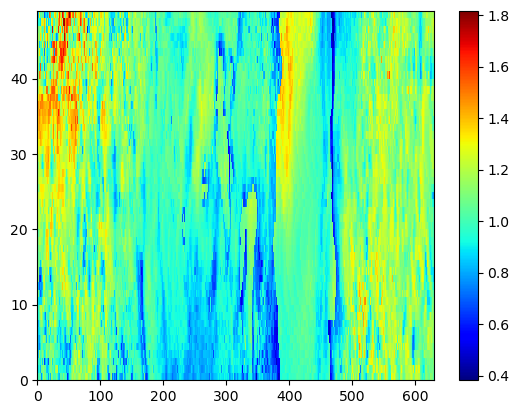

In [177]:
plt.pcolormesh((wvp_ad/wvp).T,cmap='jet')
plt.colorbar()
print(pType.max(),pType.min())

In [173]:

#plt.colorbar()
#print(x_input.mean(axis=0))
qv_ad=qv.copy()
f=wvp_ad/wvp
for i in range(qv.shape[0]):
    for j in range(qv.shape[1]):
        qv_ad[i,j,:]=qv[i,j,:]*f[i,j]

In [174]:
tb_sim_ad,tbpp_sim_ad,iwp2,rwp2,wvp_ad=sim_tb.sim_tb(sfcEmiss_ad,skTemp,envNodes,binNodes,pType,pwc,dm,airTemp,press,qv_ad,sfcBin,scorient,lookupT)

100%|██████████| 630/630 [00:10<00:00, 60.66it/s]


5071


5071it [00:09, 550.71it/s] 


(630, 49, 78, 8)
(630, 49, 78, 8)


100%|██████████| 630/630 [01:02<00:00, 10.10it/s]


In [178]:
bwy=[32.1,32.1,18.1,18.1,16.,15.6,15.6,7.2,7.2]
bwx=[19.4,19.4,10.9,10.9,9.7,9.4,9.4,4.4,4.4]
bwx=np.array(bwx)
bwy=np.array(bwy)
from numba import jit
@jit(nopython=True)
def jit_conv(a, k):
    m, n = a.shape
    m1, n1 = k.shape
    c= np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            c[i, j] = 0
            for i1 in range(-4,5):
                for j1 in range(-3,4):
                    i0=max(0, min(m-1, i+i1))
                    j0=max(0, min(n-1, j+j1))
                    c[i, j] += a[i0,j0]*k[i1+4, j1+3]
    return c

def antenna_pattern(bwx, bwy):
    bpatt=np.zeros((9,7),float)
    for i in range(9):
        for j in range(7):
            ddx=(i-4)*5
            ddy=(j-3)*5
            y2=(((ddx/bwx)**2+(ddy/bwy)**2)*4*np.log(2.))
            bpatt[i,j]=np.exp(-y2)
    return bpatt

ant_pattL=[]
for i in range(9):
    ant_patt=antenna_pattern(bwx[i], bwy[i])
    ant_pattL.append(ant_patt/ant_patt.sum())

tb_convs_L=[]
tb_ad_convs_L=[]
for ifreq in range(9):
    tb_conv=jit_conv(tbpp_sim2[:,:,ifreq],ant_pattL[ifreq])
    tb_ad_conv=jit_conv(tbpp_sim_ad[:,:,ifreq],ant_pattL[ifreq])
    #print(tb_conv.mean(),tbpp_sim2[:,:,ifreq].mean())
    tb_convs_L.append(tb_conv[:,:,np.newaxis])
    tb_ad_convs_L.append(tb_ad_conv[:,:,np.newaxis])
tb_conv=np.concatenate(tb_convs_L,axis=2)
tb_ad_conv=np.concatenate(tb_ad_convs_L,axis=2)


(200.0, 400.0)

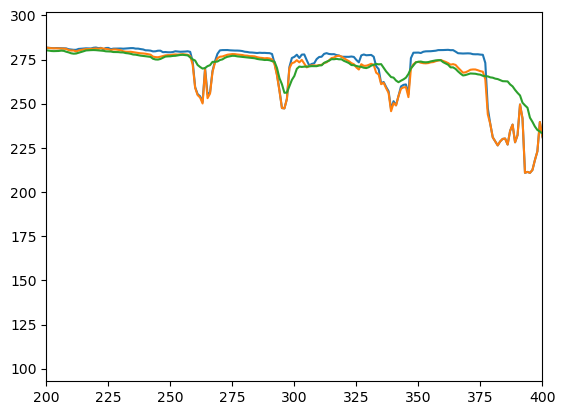

In [141]:
plt.plot(tb_conv[:,24,8])
plt.plot(tb_ad_conv[:,24,8])
plt.plot(tb_s1_resampled[:,24,8])
plt.xlim(200,400)

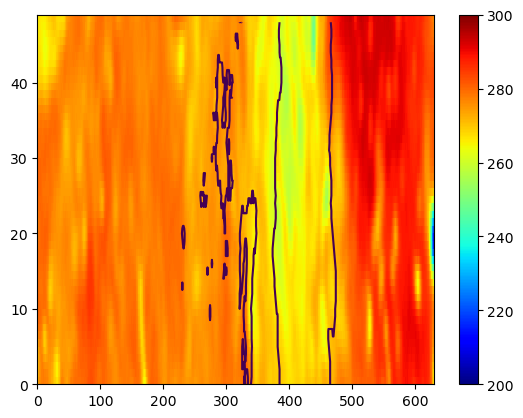

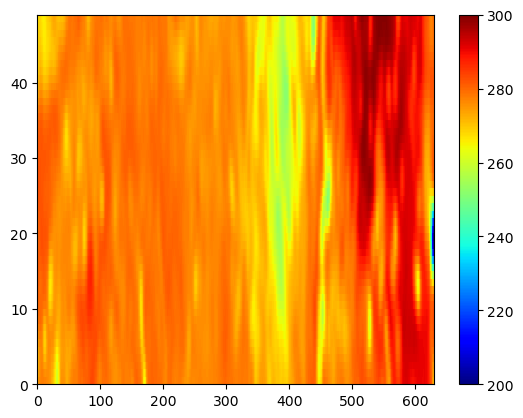

In [179]:
#plt.pcolormesh(tb_ad_conv[250:350,:,0])
#plt.colorbar()
if pType.max()>30:
    pType=pType/1e7
plt.figure()
c1=plt.pcolormesh(tb_s1_resampled[:,:,0].T,cmap='jet',vmin=200,vmax=300)
plt.contour(pType.T,levels=[1])
plt.colorbar(c1)
plt.figure()
plt.pcolormesh(tb_ad_conv[:,:,0].T,cmap='jet',vmin=200,vmax=300)
plt.colorbar()


0 0.7684711951269031 0.21323052820347174
1 0.9203967679719676 0.689105926816124
2 0.8834917311075777 0.745021561648816
3 0.9265500590605159 0.6217900988736815
4 0.8371565915283514 0.8716855060181682
5 0.9347827271868457 0.9227874414713332
6 0.9310083211804983 0.8890566433381096
7 0.8041993106169744 0.8528622531981602
8 0.7952027181691691 0.8527397177743319


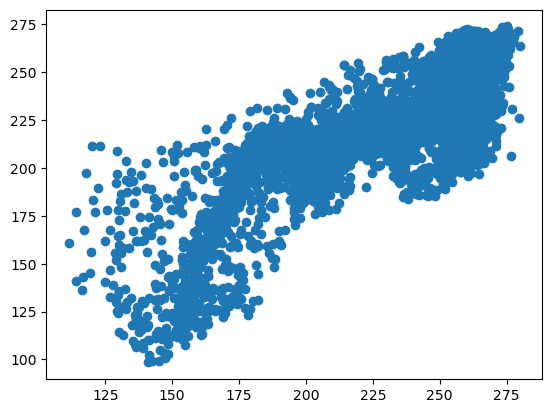

In [181]:
a=np.nonzero(pType>0)
plt.scatter(tb_s1_resampled[a][:,8],tb_ad_conv[a][:,8])
for i in range(9):
    print(i, np.corrcoef(tb_s1_resampled[a][:,i],tb_ad_conv[a][:,i])[0,1],np.corrcoef(tb_s1_resampled[a][:,i],tb_conv[a][:,i])[0,1]) 

In [192]:
rms1L=[]
rms2L=[]
a=np.nonzero(pType<0)
for i in range(9):
    rms1L.append(np.sqrt(((tb_s1_resampled[a][:,i]-tb_ad_conv[a][:,i])**2).mean())/tb_s1_resampled[a][:,i].std())
    rms2L.append(np.sqrt(((tb_s1_resampled[a][:,i]-tb_conv[a][:,i])**2).mean())/tb_s1_resampled[a][:,i].std())

([<matplotlib.axis.XTick at 0x2b46a52b0>,
 [Text(0, 0, '10-V'),
  Text(1, 0, '10-H'),
  Text(2, 0, '18-V'),
  Text(3, 0, '18-H'),
  Text(4, 0, '23-V'),
  Text(5, 0, '36-V'),
  Text(6, 0, '36-H'),
  Text(7, 0, '89-V'),
  Text(8, 0, '89-H')])

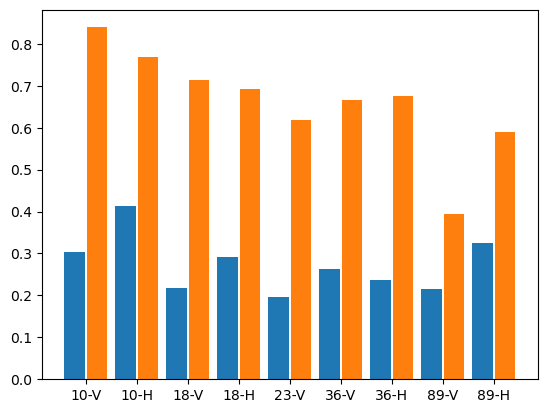

In [193]:
plt.bar(np.arange(9)-0.22,rms1L,0.4)
plt.bar(np.arange(9)+0.22,rms2L,0.4)
#add labels
plt.xticks(np.arange(9),['10-V','10-H','18-V','18-H','23-V','36-V','36-H','89-V','89-H'])

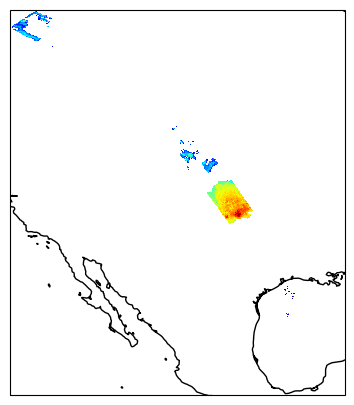

In [2]:

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon[n1:n2,:],lat[n1:n2,:],stormTop[n1:n2,:,0],cmap='jet')

In [43]:
x_inp=[]
nt,nr=lon.shape
import pickle
# read scaler from tbobs_60_120.scaler.pkl
scaler=pickle.load(open('tbobs_0_60.scaler_2.pkl','rb'))
x_sfcBinL=[]
x_owvpL=[]
x_skTempL=[]
x_zeroDegL=[]
for i in range(4,nt-5):
    for j in range(3,nr-4):
        x_inp.append(tb_s1_resampled[i-3:i+4,j-3:j+4,:])
        x_skTempL.append((skTemp[i-3:i+4,j-3:j+4]-273.15)/5)
        x_zeroDegL.append(zeroDeg[i-3:i+4,j-3:j+4]/2e3)
        x_sfcBinL.append((88-sfcBin[i-3:i+4,j-3:j+4,0:1])/30)
        x_owvpL.append((oe_wvp[i-3:i+4,j-3:j+4,np.newaxis]-22)/15.)

In [44]:
#print(x_inp.shape)
x_inp=np.array(x_inp)
x_sfcBinL=np.array(x_sfcBinL)
x_owvpL=np.array(x_owvpL)
x_skTempL=np.array(x_skTempL)
x_zeroDegL=np.array(x_zeroDegL)
print(x_inp.shape,x_sfcBinL.shape)

for i in range(9):
    x_inp[:,:,:,i]=(x_inp[:,:,:,i]-scaler.mean_[i])/scaler.scale_[i]
    


(332892, 7, 7, 9) (332892, 7, 7, 1)


In [45]:
x_forward=np.concatenate((x_inp,x_skTempL[:,:,:,np.newaxis],x_zeroDegL[:,:,:,np.newaxis],x_sfcBinL,x_owvpL),axis=3)
n1r=nt-9
n2r=nr-7
# read tensorflow from forward_model_60to120_rain_4iters.h5 
from tensorflow import keras
#discr_model=keras.models.load_model('forward_model_gmi_60to120_rain_4iters.h5')
#iprecip=discr_model.predict(x_forward).reshape(n1,n2)
#print(x_inp.shape,n1*n2)

In [46]:
print(x_inp.shape,x_skTempL.shape,x_sfcBinL.shape,x_owvpL.shape)

(332892, 7, 7, 9) (332892, 7, 7) (332892, 7, 7, 1) (332892, 7, 7, 1)


In [51]:
#load model from ("forward_model_60to120_noover_10iters.h5")

geophysics_model=keras.models.load_model("forward_model_regr_obsTb_0_120.h5")
geoParams=geophysics_model.predict(x_forward)
n1r=nt-9
n2r=nr-7
stormTop_nn=geoParams[:,-2].reshape(n1r,n2r)


10403/10403 [==============================] - 6s 570us/step


(7935, 49, 2)
4500 5500
(1000, 42)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_53651/2742007675.py:2: RuntimeWarning: overflow encountered in power
  rwp=(10**rwp-1)*10
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_53651/2742007675.py:2: RuntimeWarning: overflow encountered in multiply
  rwp=(10**rwp-1)*10


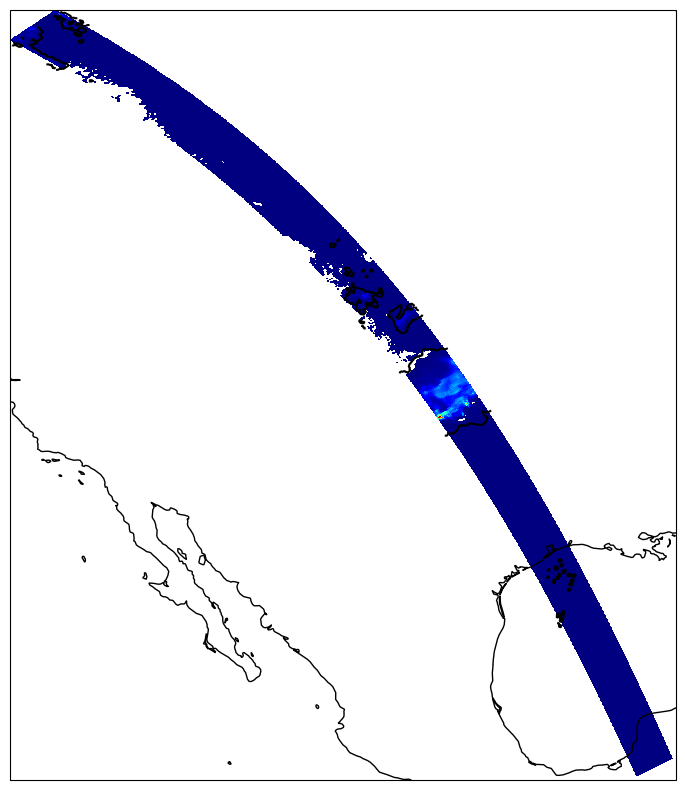

In [59]:
rwp=geoParams[:,-1].reshape(n1r,n2r)
rwp=(10**rwp-1)*10
print(stormTop.shape)
n1,n2=4500,5500
fig=plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
lon_sub=lon[n1:n2,:]
lat_sub=lat[n1:n2,:]
print(n1,n2)
stormTop_sub=stormTop_nn[n1:n2,:]
rainwp_sub=rwp[n1:n2,:]
rainwp_subm=np.ma.array(rainwp_sub,mask=rainwp_sub<0.1)
print(stormTop_sub.shape)
ax.coastlines()
c=plt.pcolormesh(lon_sub[:,3:nr-4],lat_sub[:,3:nr-4],rainwp_subm,cmap='jet')
#c=plt.pcolormesh(lon_sub[:,3:nr-4],lat_sub[:,3:nr-4],stormTop_sub,cmap='jet')
plt.contour(lon[n1+3:n2+3,:],lat[n1+3:n2+3,:],pType[n1+3:n2+3,:],levels=[1.0],colors='black')


In [ ]:

fig=plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
lon_sub=lon[n1:n2,:]
lat_sub=lat[n1:n2,:]
print(n1,n2)
stormTop_sub=stormTop_nn[n1:n2,:]
rainwp_sub=rwp[n1:n2,:]
print(stormTop_sub.shape)
ax.coastlines()
rwp=(np.exp(rainwp_sub[:,:])-1)*10.
print(rwp.shape)
emiss=geoParams[:,0].reshape(n1r,n2r)
rwpm=np.ma.array(emiss[n1:n2,:],mask=rwp<.01)
c=plt.pcolormesh(lon_sub[:,3:nr-4],lat_sub[:,3:nr-4],rwpm,cmap='jet',vmin=0.1,vmax=1.0)
plt.contour(lon[n1+3:n2+3,:],lat[n1+3:n2+3,:],pType[n1+3:n2+3,:],levels=[1.0],colors='black')
plt.colorbar(c,shrink=0.75)   
plt.savefig('rwp_nn_simTB_DB.png')

[[1.         0.74748861]
 [0.74748861 1.        ]]


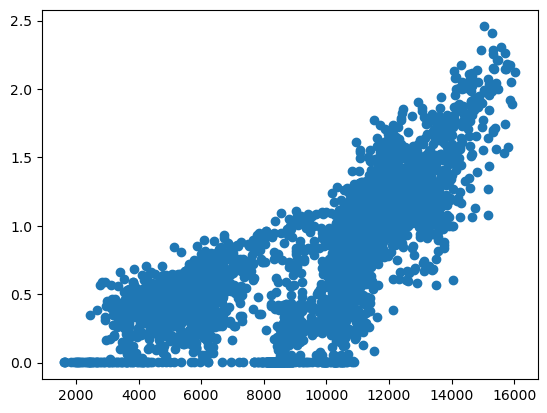

In [54]:
a=np.nonzero(stormTop[n1+3:n2+3,3:nr-4,-1]>0)
print(np.corrcoef(stormTop[n1+3:n2+3,3:nr-4,-1][a],stormTop_sub[a]))
plt.scatter(stormTop[n1+3:n2+3,3:nr-4,-1][a],stormTop_sub[a])

0.7966438507396776
0 3797


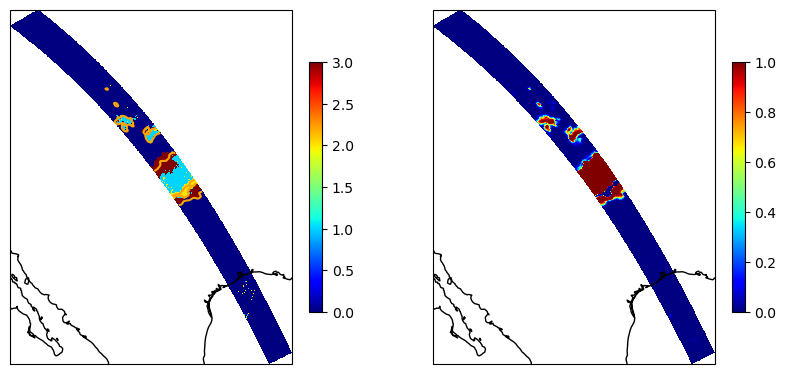

In [75]:
fig=plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
c1=plt.pcolormesh(lon[4:nt-5,3:nr-4],lat[4:nt-5,3:nr-4],pType[4:nt-5,3:nr-4]/1e7,cmap='jet')
plt.contour(lon[4:nt-5,3:nr-4],lat[4:nt-5,3:nr-4],iprecip,levels=[0.5],colors='orange')
plt.colorbar(c1,shrink=0.65)
ax.coastlines()

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
iprecipm=np.ma.array(iprecip,mask=iprecip<0.9)
plt.pcolormesh(lon[4:nt-5,3:nr-4],lat[4:nt-5,3:nr-4],iprecip,cmap='jet')
ax.coastlines()
plt.colorbar(shrink=0.65)    

a=np.nonzero(pType[4:nt-5,3:nr-4]>0)
b=np.nonzero(iprecip[a]>0.5)
print(len(b[0])/len(a[0]))

a=np.nonzero(iprecip>0.5)
b=np.nonzero(pType[a]==0)
print(len(b[0]),len(a[0]))